# Compare images and check for mode collapse
August 11, 2023

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import subprocess as sp
import os
import glob
import sys

import itertools
import time

from ipywidgets import *

In [2]:
%matplotlib notebook

In [3]:
from modules_3d_image_analysis import *

In [4]:
### Transformation functions for image pixel values
def f_transform(x,a):
    return 2.*x/(x + float(a)) - 1.

def f_invtransform(s,a):
    return float(a)*(1. + s)/(1. - s)


In [5]:
img_size=64
# img_size=128
kappa=4

In [6]:
val_data_dict={'64':'/p/vast1/lbann/datasets/exagan/portal.nersc.gov/project/m3363/transfer_data_livermore/64cube_dataset/norm_1_train_val.npy',
              '128':''}


In [23]:
def f_print_sdev_1d(arr):
    
    # c1=np.sum(arr,axis=(2,3))
    # sd=np.std(c1,axis=0)
    
    # Compute Std deviation among images. img[idx,x,y,z]
    ## axis=0 because you need variation over image index 
    sd1=np.std(arr,axis=0)[:,0,0]/np.sum(arr)
    sd2=np.std(arr,axis=0)[0,:,0]/np.sum(arr)
    sd3=np.std(arr,axis=0)[0,0,:]/np.sum(arr)
    
    return np.sum(sd1),np.sum(sd2),np.sum(sd3)


def f_plot_1d_sum(arr):
    
    # Ensure 4D array: samples,x,y,z
    assert len(arr.shape)==4, "Array must have only 4 dimensions %s. You have "%(arr.shape[0])
    assert np.min(arr)>=0, "Array has negative values. Need to be all positive for sum. min:%s\t max:%s"%(np.min(arr),np.max(arr))

    num_images=arr.shape[0]

    if num_images> 30:
        print("Too many images. Need less than or equal to 15",arr.shape)
        raise SystemExit
        
    # Get array summed along y and z axes
    a1=np.sum(arr,axis=(1,2))

#     ## Compute l1-norm for 1D array
#     b_arr=np.arange(num_images)

#     # Pick pairs of indices to compute l1-norm
#     b1=np.random.choice(b_arr,num_images//2,replace=False)
#     b2=np.array([i for i in b_arr if i not in b1])

#     val=np.zeros(num_images//2)
#     for count,(i1,i2) in enumerate(zip(b1,b2)):
#         val[count]=abs(a1[i1]-a1[i2]).sum()
        # print(np.sum(a1[i1]),np.sum(a1[i2]),np.sum(val))
    
    # print(val)
    
    fig=plt.figure()
    
    
#     fig.add_subplot(1,2,1)
#     plt.plot(val,marker='o')
    
#     fig.add_subplot(1,2,2)
#     for count,(i,marker) in enumerate(zip(arr,itertools.cycle('>^*sDHPdpx_'))):
#         plt.plot(a1[count],label=str(count),marker=marker)
        
    
    fig.add_subplot(1,1,1)
    for count,(i,marker) in enumerate(zip(arr,itertools.cycle('>^*sDHPdpx_'))):
        plt.plot(a1[count],label=str(count),marker=marker)
        
    
    plt.legend()
    plt.show()
    
    
def f_plot_sdev_1d(arr,plot=False):
    
    # c1=np.sum(arr,axis=(2,3))
    # sd=np.std(c1,axis=0)
    
    # print(arr.shape)
    # Compute Std deviation among images,
    sd1=np.std(arr,axis=0)[:,0,0]/np.sum(arr)
    sd2=np.std(arr,axis=0)[0,:,0]/np.sum(arr)
    sd3=np.std(arr,axis=0)[0,0,:]/np.sum(arr)
    # print(sd.shape)
    
    if plot: 
        plt.figure()
        plt.plot(sd1,marker='o',linestyle='-')
        plt.show()
    
    return np.sum(sd1),np.sum(sd2),np.sum(sd3)



    

In [24]:
def f_plot_image_sub(a1,diff_type='pair'):
    
    if diff_type=='pair':## Pair difference of images
        diff_arr=np.array([a1[i+1]-a1[i] for i in range(0,a1.shape[0],2)])
    
    elif diff_type=='first': ## Difference with first image
        diff_arr=np.array([a1[i+1]-a1[0] for i in range(0,a1.shape[0],2)])
        
    else: raise SystemError
        
    klist=f_batch_spectrum_3d(diff_arr)

    plt.figure()
    for i in range(klist.shape[0]):
        plt.plot(klist[i],marker='o',label=str(i))
    
    plt.legend()

In [46]:
## Module for plotting specific image metric


def f_ref_plot(a_list,img_idx,img_size,plot_type):
    
    plot_type_list=['2dslice_x','2dslice_y','2dslice_z','grid_sum_x','grid_sum_y','grid_sum_z','1d_sum','1d_sdev','img_sub']
    assert plot_type in plot_type_list, "plot type %s not in %s"%(plot_type,plot_type_list)
        
    for idx in img_idx: 
        
        images=a_list[idx] # Select specific image set
        print(images.shape)
        if plot_type=='2dslice_x': ### 2D slice
            images=images[:,img_size//2,:,:] ## Pick x slice
            f_plot_grid(images[:8],cols=4,fig_size=(8,4))

        elif plot_type=='2dslice_y': ### 2D slice
            images=images[:,:,img_size//2,:] ## Pick y slice
            f_plot_grid(images[:8],cols=4,fig_size=(8,4))
            
        elif plot_type=='2dslice_z': ### 2D slice
            images=images[:,:,:,img_size//2] ## Pick z slice
            f_plot_grid(images[:8],cols=4,fig_size=(8,4))
            
        elif plot_type=='grid_sum_x': ## Grid x sum 
            images=np.sum(f_invtransform(images,kappa),axis=1)
            # print(np.max(images),np.min(images))
            f_plot_grid(images[:8],cols=4,fig_size=(8,4))

        elif plot_type=='grid_sum_y': ## Grid y sum 
            images=np.sum(f_invtransform(images,kappa),axis=2)
            # print(np.max(images),np.min(images))
            f_plot_grid(images[:8],cols=4,fig_size=(8,4))

        elif plot_type=='grid_sum_z': ## Grid z sum 
            images=np.sum(f_invtransform(images,kappa),axis=3)
            # print(np.max(images),np.min(images))
            f_plot_grid(images[:8],cols=4,fig_size=(8,4))
            
        elif plot_type=='1d_sum':  ## 1D sum
            f_plot_1d_sum(f_invtransform(images[:8],kappa))

        elif plot_type=='1d_sdev':
            sd_metric=f_plot_sdev_1d(images[:8],0)
            print(sd_metric)
            
        elif plot_type=='img_sub':
            f_plot_image_sub(images,'pair')

    

In [47]:
a_list=[]
fname='/p/vast1/lbann/datasets/exagan/portal.nersc.gov/project/m3363/transfer_data_livermore/64cube_dataset/norm_1_train_val.npy'
arr=np.load(fname,mmap_mode='r')[740:756,0,:,:,:].copy()
a_list.append(arr)

In [48]:
fname='/usr/WS2/ayyar1/cosmogan/lbann_work/runs/runs_June19_2023/ExaGAN/20230621_055125_lbann_cosmo3DGAN_n32_D16_bs64_specloss/outputs/trainer0/model0/sgd.validation.epoch.42.step.1500_gen_img_instance1_activation_output0.npy'
arr=np.load(fname,mmap_mode='r')[:16,0,:,:,:].copy()
a_list.append(arr)

In [49]:
# f_ref_plot(a1,img_size,'grid_2dslice')

In [50]:
plot_type_list=['2dslice_x','2dslice_y','2dslice_z','grid_sum_x','grid_sum_y','grid_sum_z','1d_sum','1d_sdev','img_sub']

interact_manual(f_ref_plot,a_list=fixed(a_list),img_idx=SelectMultiple(options=np.arange(len(a_list))), img_size=fixed(img_size),
                plot_type=ToggleButtons(options=plot_type_list))


interactive(children=(SelectMultiple(description='img_idx', options=(0, 1), value=()), ToggleButtons(descripti…

<function __main__.f_ref_plot(a_list, img_idx, img_size, plot_type)>

In [51]:
def f_plot_image_sub(a1,diff_type='pair'):
    
    if diff_type=='pair':## Pair difference of images
        diff_arr=np.array([a1[i+1]-a1[i] for i in range(0,a1.shape[0],2)])
    
    elif diff_type=='first': ## Difference with first image
        diff_arr=np.array([a1[i+1]-a1[0] for i in range(0,a1.shape[0],2)])
        
    else: raise SystemError
        
    klist=f_batch_spectrum_3d(np.abs(diff_arr))

    plt.figure()
    for i in range(klist.shape[0]):
        plt.plot(klist[i],marker='o',label=str(i))
    
    plt.legend()


<IPython.core.display.Javascript object>


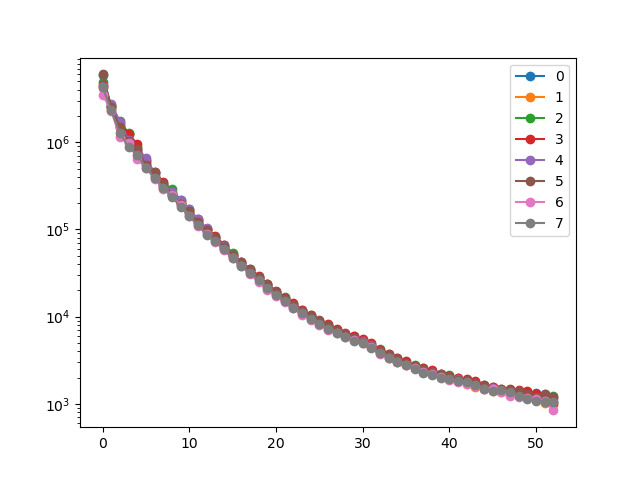

In [52]:
a1=a_list[0]
# f_plot_image_sub(a1,'pair')
f_plot_image_sub(a1,'first')
plt.yscale('log')


(8, 64, 64, 64)
-0.62145305 -0.7656703
-0.2637416 -0.2637416


<IPython.core.display.Javascript object>


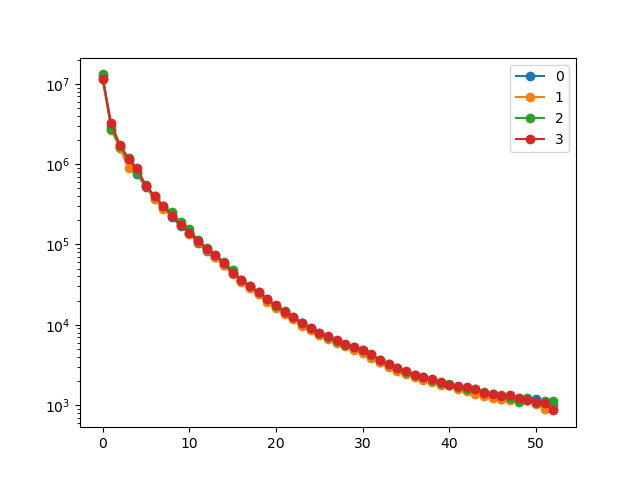

In [41]:
a2=a1[:8].copy()
print(a2.shape)
print(a2[0,1,1,1],a2[1,1,1,1])

size=a2.shape[1]
num=2
for idx in range(1,8):
    for x in range(size//num):
        for y in range(size//num):
            for z in range(size//num):
                a2[idx,x,y,z]=a2[0,x,y,z]
#                 a2[idx,x,y,z]=0.0
                
print(a2[0,1,1,16],a2[5,1,1,16])

f_plot_image_sub(a2,'first')
plt.yscale('log')
# f_plot_image_sub(a2[:,:size//num,:size//num,:size//num],'first')


In [33]:
np.sum(a2[0,:64//num,:64//num,:64//num]-a2[3,:64//num,:64//num,:64//num])

-327703360.0

<IPython.core.display.Javascript object>


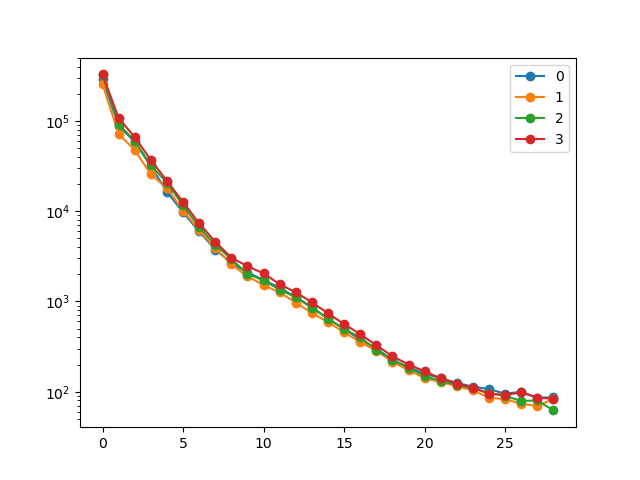

In [45]:
f_plot_image_sub(a2[:,:size//num+4,:size//num+4,:size//num+4],'first')
plt.yscale('log')


## Peaks and valleys code

In [100]:
L=64
a1 = np.random.randint(2000,size=(L,L,L))

# Flattened array. The transpose is essential for you definition of x,y,z -> site
a2=a1.T.flatten()

print(a1.shape,a2.shape)

(64, 64, 64) (262144,)


In [127]:
def f_get_site(x1,x2,x3,L):
    return x1 + x2*L + x3 * L * L

def f_get_coord(site,L):
    
    x1,x2,x3= site%L , site%(L*L)//L, site//(L* L)
    
    return x1,x2,x3 

# f_get_site(0,0,4,L=5), f_get_coord(100,L=5)

def f_get_ngb(site,L):
    
    x1,x2,x3=f_get_coord(site,L)
#     print(x1,x2,x3)

    ngb_list=[((x1+1)%L,x2,x3), ((x1-1+L)%L, x2, x3), (x1,(x2+1)%L,x3), (x1,(x2-1+L)%L, x3), (x1,x2,(x3+1)%L), (x1,x2,(x3-1+L)%L)]
    
    return ngb_list
    

def f_get_peaks_valleys(arr,L):
    
    
    peaks_list=[]
    valleys_list=[]
    for count,site in enumerate(range(len(arr))):
#         print(site)
        ngbs=f_get_ngb(site,L)
#         print(ngbs)

#         ngb_vals_list=[arr[i] for i in ngbs]
        ngb_vals_list=[arr[f_get_site(i[0],i[1],i[2],L)] for i in ngbs]

        # Get peaks and valleys        
        val = arr[site]
        if     val >= max(ngb_vals_list): peaks_list.append(val)
        elif   val <= min(ngb_vals_list): valleys_list.append(val)

            
    return sorted(peaks_list), sorted(valleys_list)


def f_get_ngb2(x1,x2,x3,L):
    
    ngb_list=[((x1+1)%L,x2,x3), ((x1-1+L)%L, x2, x3), (x1,(x2+1)%L,x3), (x1,(x2-1+L)%L, x3), (x1,x2,(x3+1)%L), (x1,x2,(x3-1+L)%L)]
    
    return ngb_list

def f_peaks_2(arr,L):
    
    
    # Get peaks and valleys
    peaks_list=[]
    valleys_list=[]
            
    for x1 in range(L):
        for x2 in range(L):
            for x3 in range(L):
            
                ngbs=f_get_ngb2(x1,x2,x3,L)
        #         print(ngbs)

                ngb_vals_list=[arr[i] for i in ngbs]
        #         ngb_vals_list=[arr[f_get_site(i[0],i[1],i[2],L)] for i in ngbs]

                val = arr[x1,x2,x3]
                if     val >= max(ngb_vals_list): peaks_list.append(val)
                elif   val <= min(ngb_vals_list): valleys_list.append(val)

    return sorted(peaks_list), sorted(valleys_list)


In [128]:
l1,l2=f_get_peaks_valleys(a2,L)

In [129]:
l3,l4=f_peaks_2(a1,L)

In [104]:
%timeit _,_=f_get_peaks_valleys(a2,L)
               

2.29 s ± 4.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [197]:
%timeit _,_=f_peaks_2(a1,L)

1.26 s ± 3.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [130]:
l1==l3, l2==l4

(True, True)

<IPython.core.display.Javascript object>


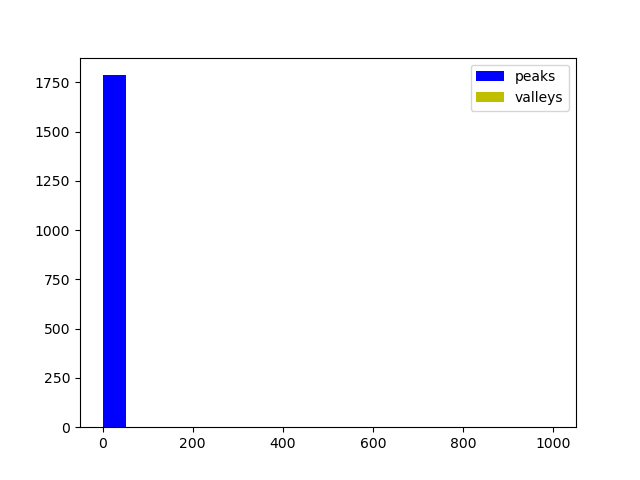

<IPython.core.display.Javascript object>


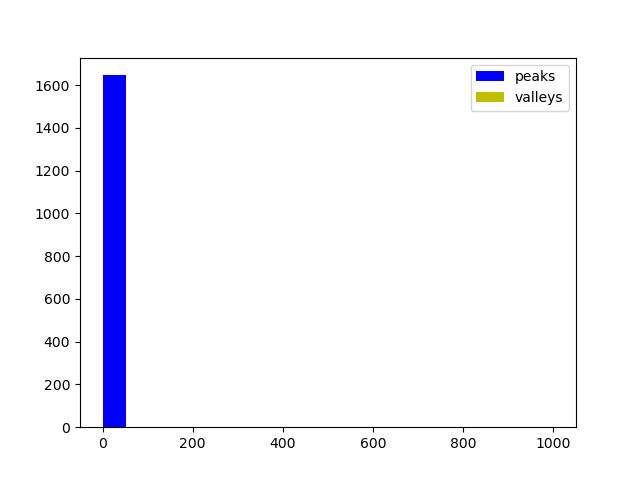

In [219]:
def f_plot_peak_valley_hist(peaks_list,valleys_list):
    
    fig=plt.figure()
    # x=df.iter.values[:210]
    # y=np.abs(df.Polyakov.values[:210])

    y1=peaks_list
    y2=valleys_list
    # hist,bins=np.histogram(y,bins=10)
    # plt.bar(np.linspace(0,0.3,10),hist)
    # plt.stairs(hist)

    bins = np.linspace(0,1000,20)
#     bins=50
    plt.hist(y1,bins=bins,color='b',label='peaks')

    plt.hist(y2,bins=bins,color='y',label='valleys')

    plt.legend(loc='best')

    
l1,l2=f_peaks_2(a_list[0][5],L)

l3,l4=f_peaks_2(a_list[1][5],L)

f_plot_peak_valley_hist(l1,l2)
f_plot_peak_valley_hist(l3,l4)

In [163]:
# a,_=np.histogram(l1,bins=50,range=(-1,1),density=True)


In [220]:
# Get avg histogram

def f_get_mean_err(arr):
    mean,err=np.mean(arr,axis=0),np.std(arr,axis=0)/np.sqrt(arr.shape[0])
    return mean,err

def f_get_hist_sample_peak_valley(img_arr,idx,L):
    
    
    l1,l2=f_peaks_2(img_arr[idx],L)
    arr1,_=np.histogram(l1,bins=50,range=(-1,1),density=True)
    arr2,_=np.histogram(l2,bins=50,range=(-1,1),density=True)
    
    return arr1,arr2


def f_get_hist_batch(arr,num_imgs=8):

    hist_list=[f_get_hist_sample_peak_valley(arr,idx,L) for idx in range(num_imgs)]

    arr1=np.array([i[0] for i in hist_list])
    arr2=np.array([i[1] for i in hist_list])
    y1,yerr1=f_get_mean_err(arr1)
    y2,yerr2=f_get_mean_err(arr2)


    return y1,yerr1,y2,yerr2



In [221]:
# y1,yerr1,y2,yerr2=f_get_hist_batch(a_list[0],num_imgs=8)
# y3,yerr3,y4,yerr4=f_get_hist_batch(a_list[1],num_imgs=8)


y1,yerr1,y2,yerr2=f_get_hist_batch(f_invtransform(a_list[0],kappa),num_imgs=8)
y3,yerr3,y4,yerr4=f_get_hist_batch(f_invtransform(a_list[1],kappa),num_imgs=8)

<IPython.core.display.Javascript object>


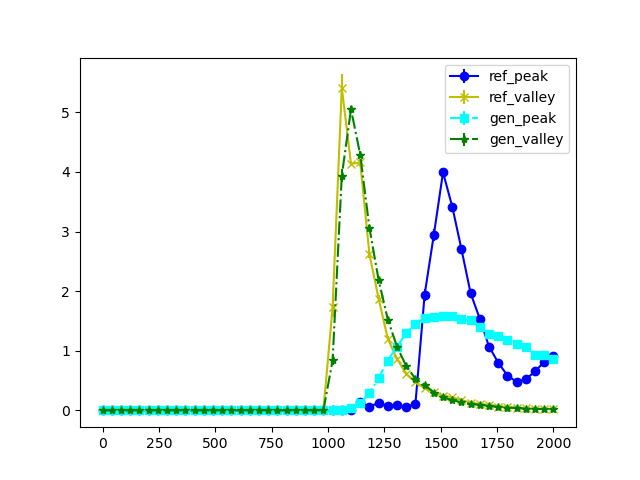

In [222]:
plt.figure()
# x=np.linspace(-1,1,50)
x=np.linspace(0,2000,50)
# plt.bar(range(50),y1)
plt.errorbar(x,y1,yerr1,linestyle='-',marker='o',color='b', label='ref_peak')
plt.errorbar(x,y2,yerr2,linestyle='-',marker='x',color='y', label='ref_valley')

plt.errorbar(x,y3,yerr3,linestyle='-.',marker='s',color='cyan', label='gen_peak')
plt.errorbar(x,y4,yerr4,linestyle='-.',marker='*',color='g', label='gen_valley')

plt.legend()
